In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 

  Activating environment at `~/Documents/PlatformIO/Projects/Cartpole/Julia/Project.toml`


In [2]:
# import Pkg; Pkg.add("LibSerialPort")
# import Pkg; Pkg.add("TickTock")

using LibSerialPort
using TickTock
using Plots


list_ports()
ports = get_port_list()

/dev/cu.wlan-debug
	Description:	wlan-debug
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.Bluetooth-Incoming-Port
	Description:	Bluetooth-Incoming-Port
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.usbserial-56230387121
	Description:	USB Single Serial
	Transport type:	SP_TRANSPORT_NATIVE


3-element Vector{String}:
 "/dev/cu.wlan-debug"
 "/dev/cu.Bluetooth-Incoming-Port"
 "/dev/cu.usbserial-56230387121"

In [3]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

**NOTE: This question will have long outputs for each cell, remember you can use `cell -> all output -> toggle scrolling` to better see it all**

## Q1: Direct Collocation (DIRCOL) for a Cart Pole (30 pts)

We are now going to start working with the NonLinear Program (NLP) Solver IPOPT to solve some trajectory optimization problems. First we will demonstrate how this works for simple optimization problems (not trajectory optimization). The interface that we have setup for IPOPT is the following:

$$ \begin{align} \min_{x} \quad & \ell(x) & \text{cost function}\\ 
 \text{st} \quad & c_{eq}(x) = 0 & \text{equality constraint}\\
 & c_L \leq c_{ineq}(x) \leq c_U & \text{inequality constraint}\\
 & x_L \leq x \leq x_U & \text{primal bound constraint}
 \end{align}$$
 
 where $\ell(x)$ is our objective function, $c_{eq}(x) = 0$ is our equality constraint, $c_L \leq c_{ineq}(x) \leq c_U$ is our bound inequality constraint, and $x_L \leq x \leq x_U $ is a bound constraint on our primal variable $x$. 
<!-- $$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} x_i^TQx_i + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}x_N^TQ_fx_N\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$ -->

## Part B: Cart Pole Swingup (20 pts)

We are now going to solve for a cartpole swingup. The state for the cartpole is the following: 

$$ x = [p,\theta,\dot{p},\dot{\theta}]^T $$ 

Where $p$ and $\theta$ can be seen in the graphic `cartpole.png`.

<div>
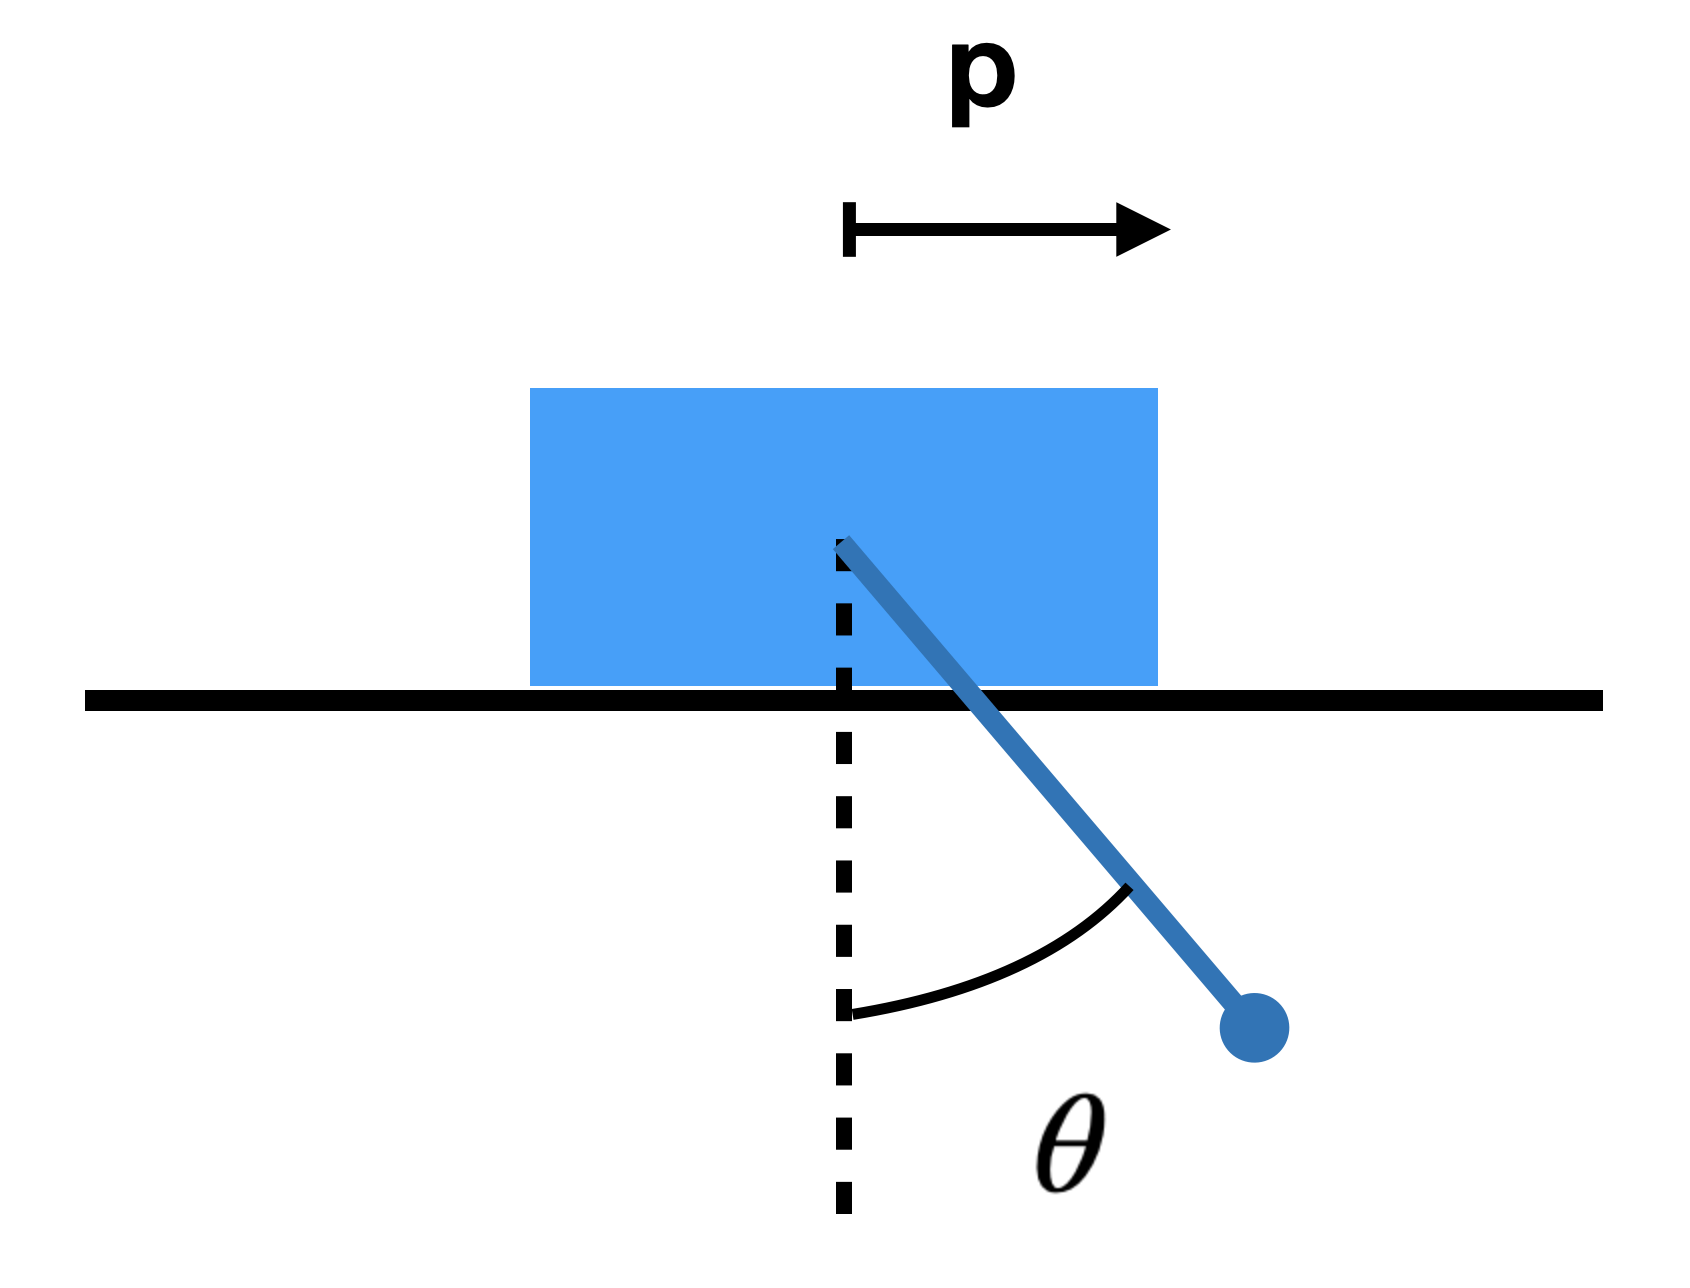
</div>

where we start with the pole in the down position ($\theta = 0$), and we want to use the horizontal force on the cart to drive the pole to the up position ($\theta = \pi$).

$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{goal})^TQ(x_i - x_{goal}) + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}(x_N - x_{goal})^TQ_f(x_N - x_{goal})\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_N = x_{goal} \\ 
 & f_{hs}(x_i,x_{i+1},u_i,dt) = 0 \quad \text{for } i = 1,2,\ldots,N-1 \\
 & -10 \leq u_i \leq 10 \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$
 
 Where $x_{IC} = [0,0,0,0]$, and $x_{goal} = [0, \pi, 0, 0]$, and $f_{hs}(x_i,x_{i+1},u_i)$ is the implicit integrator residual for Hermite Simpson (see HW1Q1 to refresh on this). Note that while Zac used a first order hold (FOH) on the controls in class (meaning we linearly interpolate controls between time steps), we are using a zero-order hold (ZOH) in this assignment. This means that each control $u_i$ is held constant for the entirety of the timestep. 

In [20]:
"""
continuous time dynamics for a cartpole, the state is 
x = [p, θ, ṗ, θ̇]
where p is the horizontal position, and θ is the angle
where θ = 0 has the pole hanging down, and θ = 180 is up.

The cartpole is parametrized by a cart mass `mc`, pole 
mass `mp`, and pole length `l`. These parameters are loaded 
into a `params::NamedTuple`. We are going to design the
controller for a estimated `params_est`, and simulate with 
`params_real`. 
"""
# cartpole 
function dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])

    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    xdot = [qd;qdd]
    return xdot 

end
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
    xmid = 0.5 * (x1 + x2) + (dt/8) * (dynamics(params,x1, u) - dynamics(params,x2, u))
    return x1 + ((dt/6) * (dynamics(params,x1, u) + 4*dynamics(params,xmid, u) + dynamics(params,x2, u))) - x2
end

hermite_simpson (generic function with 1 method)

To solve this problem with IPOPT and `fmincon`, we are going to concatenate all of our $x$'s and $u$'s into one vector:

$$ Z = \begin{bmatrix}x_1 \\ u_1 \\ x_2 \\ u_2 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} \in \mathbb{R}^{N \cdot nx + (N-1)\cdot nu} $$ 

where $x \in \mathbb{R}^{nx}$ and $u \in \mathbb{R}^{nu}$. Below we will provide useful indexing guide in `create_idx` to help you deal with $Z$.

It is also worth noting that while there are inequality constraints present ($-10 \leq u_i \leq 10$), we do not need a specific `inequality_constraints` function as an input to `fmincon` since these are just bounds on the primal ($Z$) variable. You should use primal bounds in `fmincon` to capture these constraints.  

In [21]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function cartpole_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input cartpole LQR cost 
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]

        x_dist = xi - xg

        x_cost = 0.5 * x_dist' * Q * x_dist
        u_cost = 0.5 * ui' * R * ui
       
        J += x_cost + u_cost 

    end
    
    # dont forget terminal cost 
    xn = Z[idx.x[N]]

    x_dist = xn - xg
    J += 0.5 * x_dist' * Qf * x_dist
    
    return J 
end

function cartpole_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # TODO: create dynamics constraints using hermite simpson 
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function cartpole_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    # TODO: return all of the equality constraints 
    
    # get x0 and xN
    x0 = Z[idx.x[1]]
    xN = Z[idx.x[N]]

    constraint1 = x0 - xic
    constraint2 = xN[1:4] - xg[1:4]
    dynamics = cartpole_dynamics_constraints(params, Z)

    c = [constraint1; constraint2; dynamics]

    return c
    # return zeros(10) # 10 is an arbitrary number 
end

function solve_cartpole_swingup(;verbose=true)
    
    # problem size 
    nx = 4 
    nu = 1 
    dt = 0.1
    tf = 10
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = diagm(ones(nx))
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = [0, 0, 0, 0]
    xg = [0, pi, 0, 0]
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 0.2, mp = 0.3, l = 0.4)
    
    # TODO: primal bounds 
    println("N :", N)
    x_l = -Inf * ones(idx.nz)
    x_u = Inf * ones(idx.nz)
    for i = 1:(N-1)
        # x_l[idx.u[i]] .= -10
        # x_u[idx.u[i]] .= 10

        # # limit speed to 15cm/s
        x_l[idx.x[i][3]] = -0.17
        x_u[idx.x[i][3]] = 0.17

        # # limit travel to 30 cm
        x_l[idx.x[i][1]] = -0.30
        x_u[idx.x[i][1]] = 0.30
    end

    # print(x_l)

    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)
    println("idx: ", idx)
    println("N: ", N)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
#     diff_type = :finite
    
    
    Z = fmincon(cartpole_cost,cartpole_equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end

# @testset "cartpole swingup"

solve_cartpole_swingup (generic function with 1 method)

In [22]:
X, U, t_vec = solve_cartpole_swingup(verbose=true)


# # --------------testing------------------
# # @test isapprox(X[1],zeros(4), atol = 1e-4)
# # @test isapprox(X[end], [0,pi,0,0], atol = 1e-4)
# Xm = hcat(X...)
# Um = hcat(U...)

# # --------------plotting-----------------
# display(plot(t_vec, Xm', label = ["p" "θ" "ṗ" "θ̇"], xlabel = "time (s)", title = "State Trajectory"))
# display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))

# # meshcat animation
# display(animate_cartpole(X, 0.05))


N :101
idx: 

(nx = 4, nu = 1, N = 101, nz = 504, nc = 400, x = UnitRange{Int64}[1:4, 6:9, 11:14, 16:19, 21:24, 26:29, 31:34, 36:39, 41:44, 46:49, 51:54, 56:59, 61:64, 66:69, 71:74, 76:79, 81:84, 86:89, 91:94, 96:99, 101:104, 106:109, 111:114, 116:119, 121:124, 126:129, 131:134, 136:139, 141:144, 146:149, 151:154, 156:159, 161:164, 166:169, 171:174, 176:179, 181:184, 186:189, 191:194, 196:199, 201:204, 206:209, 211:214, 216:219, 221:224, 226:229, 231:234, 236:239, 241:244, 246:249, 251:254, 256:259, 261:264, 266:269, 271:274, 276:279, 281:284, 286:289, 291:294, 296:299, 301:304, 306:309, 311:314, 316:319, 321:324, 326:329, 331:334, 336:339, 341:344, 346:349, 351:354, 356:359, 361:364, 366:369, 371:374, 376:379, 381:384, 386:389, 391:394, 396:399, 401:404, 406:409, 411:414, 416:419, 421:424, 426:429, 431:434, 436:439, 441:444, 446:449, 451:454, 456:459, 461:464, 466:469, 471:474, 476:479, 481:484, 486:489, 491:494, 496:499, 501:504], u = UnitRange{Int64}[5:5, 10:10, 15:15, 20:20, 25:25, 30:30, 35:35,

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------


---------testing constraint Jacobian----------------


---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   205632
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      504
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality co

([[2.658114043041656e-27, 4.199474720139163e-26, 2.4304111944259282e-26, -5.2854742965681725e-27], [-0.0030550339816430346, 0.007476951425390083, -0.05926479334222292, 0.14189253157185608], [-0.009175121640967633, 0.0206602056606336, -0.05990529401081897, 0.10830619894688978], [-0.01573065998173913, 0.02994892235980852, -0.06893254072902702, 0.0679912187426171], [-0.02356647282722958, 0.035180112075625505, -0.08650504481658855, 0.03129921117905115], [-0.0333415343434915, 0.03670977590807047, -0.10862245282497601, -0.0022650245767721453], [-0.04530789717721367, 0.03478711618724945, -0.13117461251376794, -0.03422835729498236], [-0.05931297258260556, 0.029500584697150327, -0.15021948553104664, -0.06611135130668036], [-0.0748184029785695, 0.020802577023705585, -0.16201808948171478, -0.098972830837872], [-0.09092390045008754, 0.00857862813631012, -0.16308793087553555, -0.13302083721822505]  …  [-0.07317737714253031, 0.8061635980846241, -0.17000000999996237, 9.045224988760806], [-0.084184838

In [23]:
jldsave("cartpole_swingup_backup2.jld2"; X, U, t_vec)

In [24]:
# saveFile = jldopen("cartpole_swingup_backup2.jld2", "r")
# X_save= read(saveFile, "X")
# U_save = read(saveFile, "U")
# t_vec_save = read(saveFile, "t_vec")
# println("X_save: ", X_save)

## Part C: Track DIRCOL Solution (5 pts)

Now, similar to HW2 Q2 Part C, we are taking a solution $X$ and $U$ from DIRCOL, and we are going to track the trajectory with TVLQR to account for model mismatch. While we used hermite-simpson integration for the dynamics constraints in DIRCOL, we are going to use RK4 for this simulation. Remember to clamp your control to be within the control bounds. 

In [25]:
function ihlqr(A::Matrix,       # vector of A matrices 
    B::Matrix,       # vector of B matrices
    Q::Matrix,       # cost matrix Q 
    R::Matrix;       # cost matrix R 
    max_iter = 10000, # max iterations for Ricatti 
    tol = 1e-5       # convergence tolerance
    )::Tuple{Matrix, Matrix} # return two matrices 

    # get size of x and u from B 
    nx, nu = size(B)

    # initialize S with Q
    P = deepcopy(Q)
    K = deepcopy(Q)

    # Ricatti 
    for ricatti_iter = 1:max_iter 
        K = (R + B'*P*B)\(B'*P*A)
        Pnew = Q + A'*P*(A-B*K)
        if norm(P - Pnew) < tol 
            break
        end
        
        # print("ihlqr iteration: ", ricatti_iter, " norm(P - Pnew) = ", norm(P - Pnew), "\n")
        P = deepcopy(Pnew)
        if ricatti_iter == max_iter
        error("ihlqr did not converge")
        end
    end

    return P, K
end

ihlqr (generic function with 1 method)

In [51]:
function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

# @testset "track cartpole swingup with TVLQR" begin 
    ENCODER_LINEAR_ANGULAR_RATIO_M = 0.00602;
    ENCODER_LINEAR_ANGULAR_RATIO_CM = 0.602;
    ENCODER_ELBOW_ANGULAR_RATIO= 0.2;
    ENCODER_SHOULDER_ANGULAR_RATIO = 1.0;
    
    # X_dircol, U_dircol, t_vec, params_dircol = solve_cartpole_swingup(verbose = false)
    X_dircol = X
    U_dircol = U

    speed_mult = 22222
    nx = 4 
    nu = 1 
    dt = 0.02
    tf = 10
    t_vec = 0:dt:tf 
    N = length(t_vec)

    # LQR cost 
    Q = diagm(ones(nx))
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = [0, 0, 0, 0]
    xg = [0, pi, 0, 0]
    params_dircol = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = 0.1, N = N, idx = idx,mc = 0.2, mp = 0.3, l = 0.4)
    
    # N = length(X_dircol)
    dt_dircol = params_dircol.dt 
    x0 = X_dircol[1]
    u0 = U_dircol[1]
    N_dircol = length(X_dircol)
    t_vec_dircol = 0:dt_dircol:tf
    
    # use this for TVLQR tracking cost 
    Q = diagm([1,1,.05,.1])
    Qf = 100*Q
    R = 0.0001*diagm(ones(1))

    # TODO: use TVLQR to generate K's 
    
    # A = ForwardDiff.jacobian(dx -> rk4(params_dircol, dx, u0, dt), x0)
    # B = ForwardDiff.jacobian(du -> rk4(params_dircol, x0, du, dt), u0) 
    Q = diagm([0,0,1,1])
    R = 0.01*diagm(ones(1))
    # P, K = ihlqr(A, B, Q, R)
    
    # simulation
    Xsim = [zeros(4) for i = 1:N]
    Usim = [zeros(1) for i = 1:(N-1)]
    Xsim[1] = 1*x0 

    velocity = [x[3] for x in X_dircol]

    
    # here are the real parameters (different than the one we used for DIRCOL)
    # this model mismatch is what's going to require the TVLQR controller to track
    # the trajectory successfully. 
    # params_real = (mc = 1.05, mp = 0.21, l = 0.48)

    linearPositions = zeros(N)
    elbowPositions = zeros(N)
    linearVelocities = zeros(N)
    elbowVelocities = zeros(N)
    shoulderPositions = zeros(N)
    shoulderVelocities = zeros(N)
    elbowRequested = zeros(N)
    linearRequested = zeros(N)

    println(N)
    
    freq = dt_dircol / dt
    
    println("freq: ", freq)
    println("dt dircol: ", dt_dircol)

    velocities_strings = ["0.0" for i = 1:N]
    for i = 1:N
        index = floor(Int, i / freq) + 1
        velocities_strings[i] = string(round(velocity[index] * speed_mult, digits=1))
    end


# end

501
freq: 5.0
dt dircol: 0.1


In [82]:

sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 38400)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)

encoders = readline(sp)
encoders = readline(sp)
encodersSplit = split(encoders, ",")
command = "<0, 0>"
write(sp, command)

linearBaseLine = parse(Float64, encodersSplit[1]) * ENCODER_LINEAR_ANGULAR_RATIO_M
shoulderBaseLine = parse(Float64, encodersSplit[3])
shoulderBaseLine = 0.35
println("linearBaseLine: ", linearBaseLine)
println("shoulderBaseLine: ", shoulderBaseLine)

# TODO: simulate closed loop system 
x_sim_i = [0, 0, 0, 0]
tick()
for i = 1:(N-1)
    # TODO: add feeback control (right now it's just feedforward)
    # x_i = Xsim[i]
    # u_i = U_dircol[i] - K*(x_i - X_dircol[i])
    # u_i = clamp.(u_i, -10, 10) # update this

    # Usim[i] = u_i
    # Xsim[i+1] = rk4(params_real, Xsim[i], Usim[i], dt) 

    # A = ForwardDiff.jacobian(dx -> rk4(params_dircol, dx, u_i, dt), Xsim[i+1])
    # B = ForwardDiff.jacobian(du -> rk4(params_dircol, Xsim[i+1], du, dt), u_i)

    # P, K = ihlqr(A, B, Q, R)

    # println(i)
    start = time()
    index = floor(Int, i / freq) + 1

    encoded = false
    try 
        # read twice for timing issues
        encoders = readline(sp)
        encoders = readline(sp)
        encodersSplit = split(encoders, ",")
    
        velocity_string = velocities_strings[i]
        command = "<0, " * velocity_string * ">"
        # command = "<0, 0>"
        write(sp, command)
        
        linearPositions[i] = parse(Float64, encodersSplit[1]) * ENCODER_LINEAR_ANGULAR_RATIO_M
        linearVelocities[i] = parse(Float64, encodersSplit[2]) * ENCODER_LINEAR_ANGULAR_RATIO_M
        shoulderPositions[i] = parse(Float64, encodersSplit[3])
        shoulderVelocities[i] = parse(Float64, encodersSplit[4])
        elbowPositions[i] = parse(Float64, encodersSplit[5]) * ENCODER_ELBOW_ANGULAR_RATIO
        elbowVelocities[i] = parse(Float64, encodersSplit[6]) * ENCODER_ELBOW_ANGULAR_RATIO
        encoded = true
    catch
        # println("error", i)
    end

    if encoded
        x_sim_i = [linearPositions[i], shoulderPositions[i], linearVelocities[i], shoulderVelocities[i]]
    end
    Xsim[i] = x_sim_i

    elapsedTime = time() - start
    sleep(max(0, (dt - elapsedTime) * 0.9))
end
tock()

write(sp, "<0, 0>") # first is elbow, second is linear rail
close(sp)

linearBaseLine: 0.1132362
shoulderBaseLine: 0.35


┌ Info:  started timer at: 2023-05-05T10:26:44.301
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:54
┌ Info:         12.496550417s: 12 seconds, 496 milliseconds
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:62


In [ ]:
# save results
jldsave("cartpole_swingup_results.jld2"; Xsim, Usim, t_vec_dircol, linearPositions, shoulderPositions, elbowPositions, linearVelocities, shoulderVelocities, elbowVelocities, linearRequested, elbowRequested)

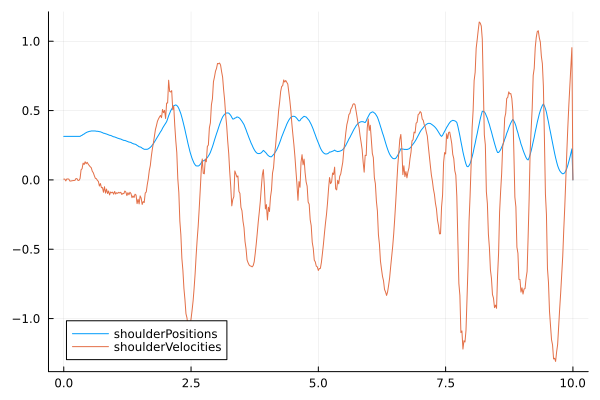

In [83]:
plot(t_vec, shoulderPositions, label = "shoulderPositions")
plot!(t_vec, shoulderVelocities, label = "shoulderVelocities")




# plot(t_vec, linearPositions)
# plot(t_vec, linearVelocities)

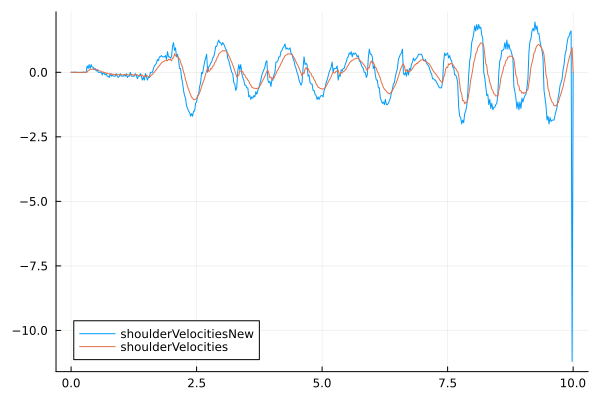

In [84]:
# calculate shoulderVelocities manually
shoulderVelocitiesNew = zeros(N)
for i = 1:(N-1)
    shoulderVelocitiesNew[i] = (shoulderPositions[i+1] - shoulderPositions[i]) / (dt)
end
# shoulderVelocitiesNew = clamp.(shoulderVelocitiesNew, -0.4, 0.4)

plot(t_vec, shoulderVelocitiesNew, label = "shoulderVelocitiesNew")
plot!(t_vec, shoulderVelocities, label = "shoulderVelocities")

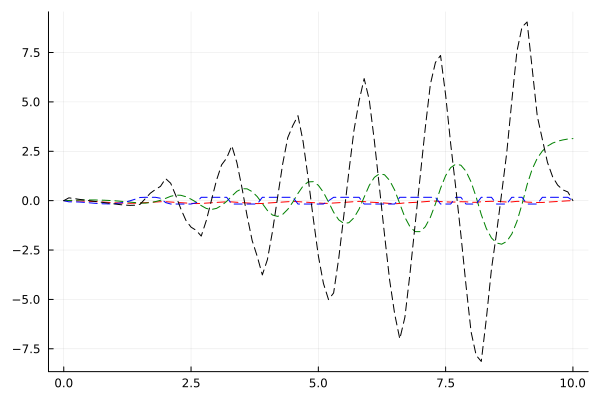

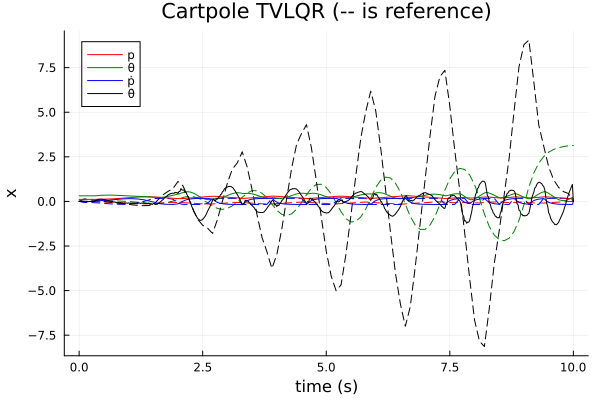

In [86]:
    # -----------------testing-----------------------
    # xn = Xsim[N]
    t_vec_dircol = 0:0.1:tf 
    # -----------------plotting----------------------
    Xm = hcat(Xsim...)
    Xbarm = hcat(X_dircol...)
    display(plot(t_vec_dircol,Xbarm',ls=:dash, label = "",lc = [:red :green :blue :black]))
    display(plot!(t_vec,Xm',title = "Cartpole TVLQR (-- is reference)",
                 xlabel = "time (s)", ylabel = "x",
                 label = ["p" "θ" "ṗ" "θ̇"],lc = [:red :green :blue :black]))

    
    # Um = hcat(Usim...)
    # Ubarm = hcat(U_dircol...)
    # plot(t_vec[1:end-1],Ubarm',ls=:dash,lc = :blue, label = "")
    # display(plot!(t_vec[1:end-1]?,Um',title = "Cartpole TVLQR (-- is reference)",
    #              xlabel = "time (s)", ylabel = "u",lc = :blue, label = ""))
    
    # ----------------animate------------------------
    # display(animate_cartpole(Xsim, 0.05))